In [1]:
import os

datadir = "/Users/michielk/oxdata/P01/EM/Myrf_01/SET-B/B-NT-S10-2f_ROI_00/blocks_0500"
pred_file = os.path.join(datadir, 'B-NT-S10-2f_ROI_00_00480-01020_00480-01020_00000-00184_probs_vol01+vol06.h5')  # dataset: 'data'
aff_file = os.path.join(datadir, 'B-NT-S10-2f_ROI_00_00480-01020_00480-01020_00000-00184_probs_vol01+vol06_absgrad.h5')  # dataset: 'main'
out_folder = os.path.join(datadir, 'zws_vol00_')
outname = os.path.join(datadir, 'B-NT-S10-2f_ROI_00_00480-01020_00480-01020_00000-00184_probs_zws.h5')  # dataset: 'main'
max_len = 300


In [ ]:
# in conda root env
import h5py
import numpy as np
from wmem import utils

h5path_in = os.path.join(pred_file, 'data')
h5file_in, ds_in, elsize, axlab = utils.h5_load(h5path_in)
grad = np.array(np.absolute(np.gradient(ds_in[:], 1)))

h5file_in.close()

h5path_out = os.path.join(datadir, 'B-NT-S10-2f_ROI_00ds7_probs_main_vol00_absgrad.h5', 'main')
h5file_out, ds_out = utils.h5_write(None, grad.shape, grad.dtype,
                                    h5path_out,
                                    element_size_um=np.insert(elsize, 0, 1),
                                    axislabels=np.insert(axlab, 0, 'c'))
ds_out[:] = grad
h5file_out.close()


In [2]:
from zwatershed import (partition_subvols,
                        eval_with_par_map,
                        eval_with_spark,
                        stitch_and_save,
                        merge_by_thresh)


In [ ]:
partition_data = partition_subvols(aff_file, out_folder, max_len)


In [ ]:
eval_with_spark(partition_data[0])
# NUM_WORKERS=4
# eval_with_par_map(partition_data[0], NUM_WORKERS)


In [ ]:
stitch_and_save(partition_data, outname)


In [3]:
%matplotlib nbagg

import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import product
from zwatershed import (partition_subvols,
                        eval_with_par_map,
                        stitch_and_save,
                        merge_by_thresh)
# from par_funcs import *
# sys.path.append('..')
cmap = matplotlib.colors.ListedColormap(np.vstack( ((0, 0, 0), np.random.rand(1e6, 3))) )
V = 60


/Users/michielk/anaconda/envs/zwatershed/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


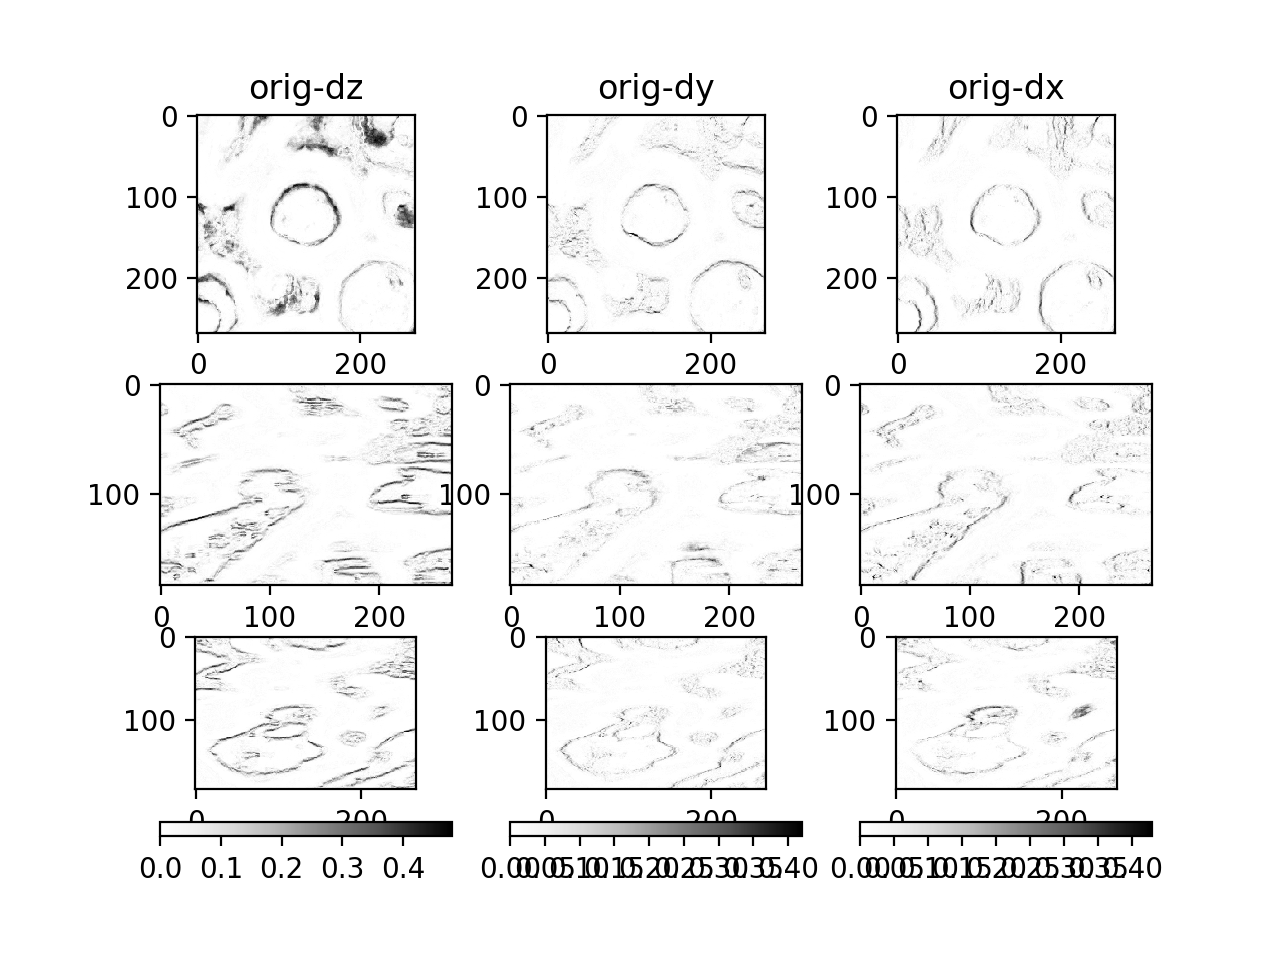

In [4]:
orig_file = h5py.File(aff_file,'r')
start = np.array([0, 0, 0])
stop = np.array([184, 267, 267])
fig, axs = plt.subplots(3, 3)
for i, dim in enumerate('zyx'):
    orig = orig_file['main'][i, start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
    slcs = [orig[V,:,:], orig[:,V,:], orig[:,:,V]]
    for j, slc in enumerate(slcs):
        ax = axs[j, i]
        if j == 0:
            ax.set_title('orig-d{}'.format(dim))
        cax = ax.imshow(slc, cmap=plt.get_cmap('Greys'))
    cbar = fig.colorbar(cax, ax=ax, orientation='horizontal')
orig_file.close()
plt.show()


<IPython.core.display.Javascript object>


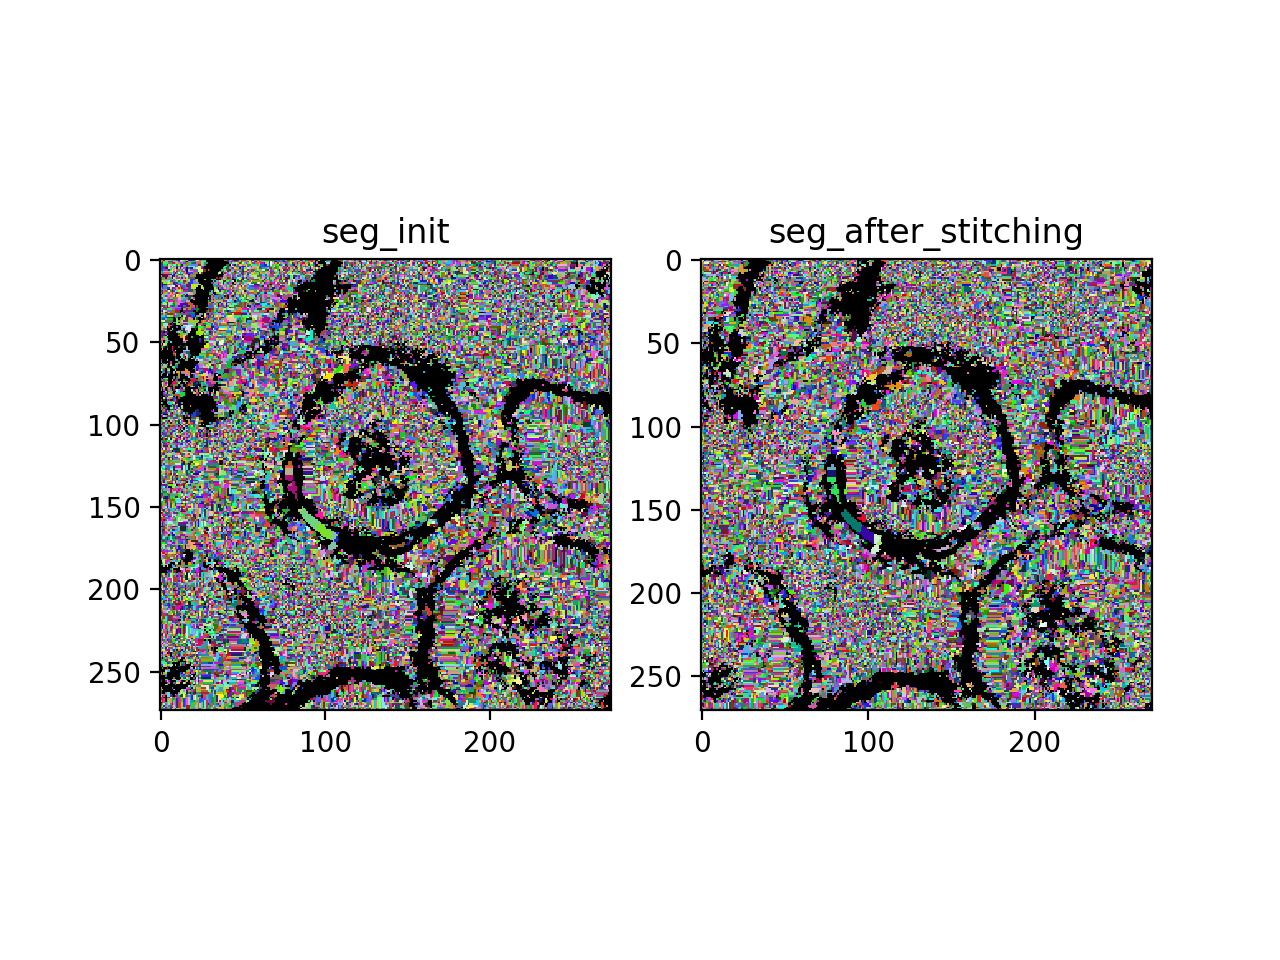

num_segs 2170994 2129897
rg lens 9773005 9772899


In [6]:
volnum, vol = 0, 'zws_vol00_0_0_0_vol'

fig, axs = plt.subplots(1, 2)

basic_file = h5py.File(os.path.join(datadir, vol, 'basic.h5'),'r')
seg_init = np.array(basic_file['seg'])
rg_init = np.array(basic_file['rg'])
keeps = rg_init[:, 0] < rg_init[:, 1]
rg_init = rg_init[keeps, :]
seg_sizes_init = np.array(basic_file['counts'])
basic_file.close()

ax = axs[0]
ax.imshow(seg_init[V,:,:], cmap=cmap)
ax.set_title('seg_init')

f = h5py.File(outname, 'a')
s, e = f['starts'][volnum], f['ends'][volnum]
seg = f['seg'][s[0]:e[0]-3, s[1]:e[1]-3, s[2]:e[2]-3]
seg_sizes = np.array(f['seg_sizes'])
rg = np.array(f['rg_' + str(volnum)])
f.close()

ax = axs[1]
ax.imshow(seg[V,:,:], cmap=cmap)
ax.set_title('seg_after_stitching')

plt.show()

print "num_segs",len(np.unique(seg_init)),len(np.unique(seg))
print "rg lens",len(rg_init),len(rg)


In [7]:
print rg_init.shape, seg_init.shape, seg_sizes_init
print rg.shape, seg.shape, seg_sizes
print(np.mean(rg, axis=0))

(9773005, 3) (184, 274, 274) [2412536      16       8 ...,       2       4       3]
(9772899, 3) (184, 271, 271) [5644966      16       8 ...,       2       5       3]
[  1.06974050e+06   1.07830238e+06   2.88282167e-02]


In [10]:
# num_segs: 2129897
# thresh = 1000000000000  # 
thresh = 1000000000000  # num_segs_merged: 711069 ON FRESH RUN: num_segs_merged: 308832
# thresh = 10000000000  # num_segs_merged: 645606
# thresh = 100000000  # num_segs_merged: 1018560
# thresh = 10000000  # num_segs_merged: 1824137
# thresh = 1000000  # num_segs_merged: 2125439
# thresh = 500000  # num_segs_merged: 2128960
# thresh = 100000  # num_segs_merged: 2129897
# thresh = 50000  # num_segs_merged: 2129897
# thresh = 10000  # num_segs_merged: 2129897

# seg_init_merged = merge_by_thresh(seg_init, seg_sizes_init, rg_init, thresh)
# print "num_segs", len(rg_init), len(np.unique(seg_init)), len(np.unique(seg_init_merged))

seg_merged = merge_by_thresh(seg, seg_sizes, rg, thresh)
print "len rg: {}, num_segs: {},  num_segs_merged: {}".format(len(rg), len(np.unique(seg)), len(np.unique(seg_merged)))


calculating renums...
filtering renums...
renumbering...
len rg: 9772899, num_segs: 2129897,  num_segs_merged: 908321


In [ ]:
print "len rg: {}, num_segs: {},  num_segs_merged: {}".format(len(rg), len(np.unique(seg)), len(np.unique(seg_merged)))


<IPython.core.display.Javascript object>


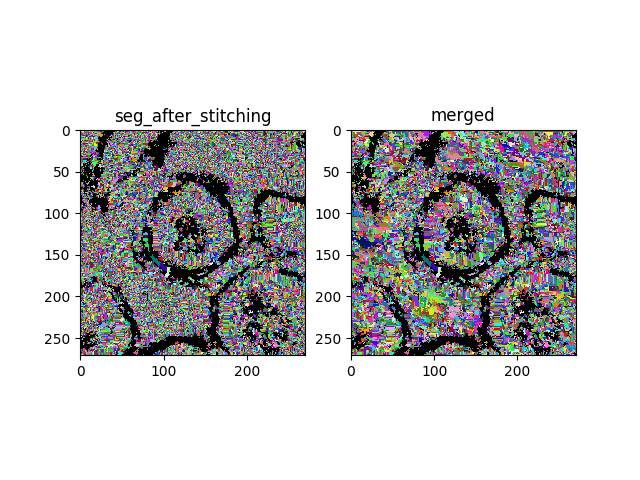

In [11]:
fig, axs = plt.subplots(1, 2)

# ax = axs[0]
# ax.imshow(seg_init_merged[V,:,:], cmap=cmap)
# ax.set_title('merged init')

ax = axs[0]
ax.imshow(seg[V,:,:], cmap=cmap)
ax.set_title('seg_after_stitching')

ax = axs[1]
ax.imshow(seg_merged[V,:,:], cmap=cmap)
ax.set_title('merged')

plt.show()
